# Water Contamination(Chemical) Level Predictions Using Bayesian Statistics

## Introduction

Welcome to our journey into the world of drinking water safety, where data meets public health to ensure a cleaner and safer future for everyone. Water contamination is a critical global issue, and understanding the risks of contaminant exceedance can save lives, enhance regulatory compliance, and improve public trust.

![Alt text](image-1.jpg)

### Why Focus on Drinking Water Safety?

Safe drinking water is fundamental to human health and well-being. Contaminants exceeding health or legal limits in water can lead to severe health risks, environmental degradation, and regulatory challenges. This project aims to leverage advanced machine learning techniques to predict and mitigate these risks effectively.

### Interesting Facts

**Global Water Crisis:**
1. Over 2 billion people globally lack access to safe drinking water, according to the World Health Organization (WHO).
2. By 2025, half of the world’s population is expected to live in water-stressed areas.
    
**Health Impact of Contaminants:**
1. Nitrate contamination in drinking water can cause "blue baby syndrome," a condition that reduces oxygen flow in infants' blood.
2. Long-term exposure to contaminants like chromium-6 is linked to cancer and other severe health risks.

**Economic Impact:**
1. The economic losses from inadequate water supply and sanitation cost developing countries $260 billion annually.


In this notebook, we’ll explore a comprehensive dataset of water suppliers, contaminants, and historical violations to uncover patterns and insights that influence drinking water safety.We aim to predict and mitigate risks associated with contaminants exceeding health or legal limits. Whether you’re a public health advocate, a data science enthusiast, or someone passionate about water safety, there’s something here for everyone

## Importing and Installing Libraries

In [1]:
!pip install -r requirements.txt

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import pymc3 as pm
import arviz as az
import ace_tools_open as tools
sns.set_context('notebook')
np.random.seed(0) # to keep it reproducible

RANDOM_SEED = 20090425

WARN: Could not locate executable g77
WARN: Could not locate executable f77
WARN: Could not locate executable ifort
WARN: Could not locate executable ifl
WARN: Could not locate executable f90
WARN: Could not locate executable DF
WARN: Could not locate executable efl
WARN: Could not locate executable gfortran
WARN: Could not locate executable f95
WARN: Could not locate executable g95
WARN: Could not locate executable efort
WARN: Could not locate executable efc
WARN: Could not locate executable flang
WARN: don't know how to compile Fortran code on platform 'nt'


WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.


### Reading Data

**Dataset : https://data.world/arnholdinst/drinking-water-contaminations**

In [3]:
contaminants = pd.read_csv("contaminants.csv")

In [4]:
suppliers=pd.read_csv('suppliers.csv')

In [5]:
violations=pd.read_csv('violation_summaries.csv')

In [6]:
# Define key columns
key_columns = ['id', 'zipcode', 'supplier_name', 'locations_served']

# Step 1: Remove duplicates
cleaned_contaminants = contaminants.drop_duplicates(subset=key_columns)
cleaned_violations = violations.drop_duplicates(subset=key_columns)

# Step 2: Drop rows with missing key columns
cleaned_suppliers = suppliers.dropna(subset=key_columns)
cleaned_violations = cleaned_violations.dropna(subset=key_columns)

# Step 3: Merge contaminants and suppliers
merged_data = pd.merge(
    cleaned_contaminants,
    cleaned_suppliers,
    on=['id', 'zipcode', 'supplier_name', 'locations_served'],
    how='inner'
)

# Step 4: Merge with violation summaries
final_data = pd.merge(
    merged_data,
    cleaned_violations,
    on=['id', 'zipcode', 'supplier_name', 'locations_served'],
    how='inner'
)

final_data.drop(columns=["number_of_people_served_x","href_x","number_of_people_served_y","href_y","href"],inplace=True)


final_data.to_csv("final_data.csv")

In [7]:
# Function to extract the value and unit from health and legal limit columns
def extract_value(column):
    return column.str.extract(r'([0-9.]+\s?\w+)')[0]

# Creating new flag columns for "Yes" or "No"
final_data['health_limit_flag'] = final_data['health_limit_exceeded'].str.contains('Yes', case=False, na=False).map({True: 'Yes', False: 'No'})
final_data['legal_limit_flag'] = final_data['legal_limit_exceeded'].str.contains('Yes', case=False, na=False).map({True: 'Yes', False: 'No'})

# Apply the function to the specified columns
final_data['health_limit_exceeded'] = extract_value(final_data['health_limit_exceeded'])
final_data['legal_limit_exceeded'] = extract_value(final_data['legal_limit_exceeded'])

final_data.to_csv("final_data.csv")

In [8]:
final_data=pd.read_csv("final_data.csv")

### Preliminary Data Analysis

This Analysis shows some basic statistics, initial exploration, structure and summary of data

In [9]:
contaminants.info()
print("The size of this dataset is: ",contaminants.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367289 entries, 0 to 367288
Data columns (total 11 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   id                       367289 non-null  int64 
 1   contaminant              367289 non-null  object
 2   average_result           367289 non-null  object
 3   max_result               367289 non-null  object
 4   health_limit_exceeded    367289 non-null  object
 5   legal_limit_exceeded     367289 non-null  object
 6   zipcode                  367289 non-null  int64 
 7   locations_served         274944 non-null  object
 8   supplier_name            367289 non-null  object
 9   number_of_people_served  367289 non-null  int64 
 10  href                     367289 non-null  object
dtypes: int64(3), object(8)
memory usage: 30.8+ MB
The size of this dataset is:  (367289, 11)


In [10]:
violations.info()
print("The size of this dataset is: ",violations.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231616 entries, 0 to 231615
Data columns (total 8 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   id                       231616 non-null  int64 
 1   violation                231616 non-null  object
 2   date_of_violation        231616 non-null  object
 3   zipcode                  231616 non-null  int64 
 4   locations_served         173756 non-null  object
 5   supplier_name            231616 non-null  object
 6   number_of_people_served  231616 non-null  int64 
 7   href                     231616 non-null  object
dtypes: int64(3), object(5)
memory usage: 14.1+ MB
The size of this dataset is:  (231616, 8)


In [11]:
# Describing data
contaminants.describe()

,id,zipcode,number_of_people_served
count,3.672890e+05,367289.000000,3.672890e+05
mean,1.579459e+05,53449.591635,1.163351e+04
std,2.111160e+05,28698.115098,1.686601e+05
min,1.000000e+00,1003.000000,1.000000e+00
25%,1.905200e+04,28016.000000,1.430000e+02
50%,6.073700e+04,56401.000000,5.910000e+02
75%,2.846880e+05,77345.000000,3.000000e+03
max,1.751691e+06,99928.000000,1.700000e+07


In [12]:
# To find is there any null data in contaminants data
contaminants.isnull().sum(axis=0)

id                             0
contaminant                    0
average_result                 0
max_result                     0
health_limit_exceeded          0
legal_limit_exceeded           0
zipcode                        0
locations_served           92345
supplier_name                  0
number_of_people_served        0
href                           0
dtype: int64

In [13]:
# To find is there any null data in violations data
violations.isnull().sum(axis=0)

id                             0
violation                      0
date_of_violation              0
zipcode                        0
locations_served           57860
supplier_name                  0
number_of_people_served        0
href                           0
dtype: int64

### Intermittent Data Analysis

**"Which locations have the highest number of contaminant violations (health or legal)?"**

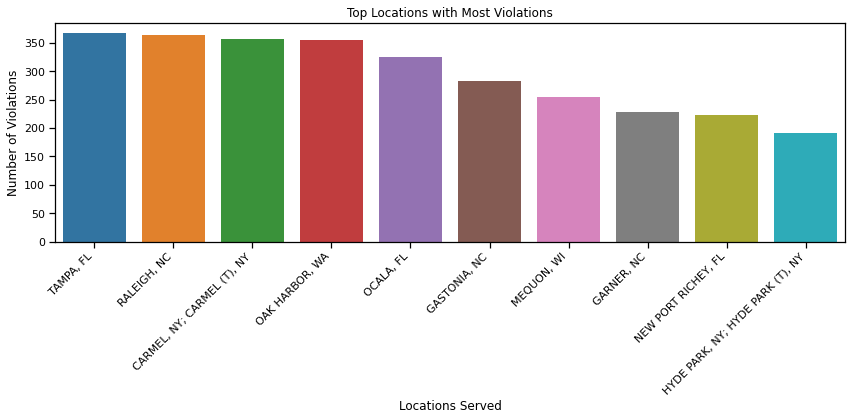

In [14]:
# Filter the data for violations and count occurrences
violations_count = contaminants[
    contaminants['health_limit_exceeded'].str.contains('Yes', na=False) |
    contaminants['legal_limit_exceeded'].str.contains('Yes', na=False)
]['locations_served'].value_counts()

# Limit to the top 10 locations with the most violations
top_violations = violations_count.iloc[:10]

# Create the plot
plt.figure(figsize=(12, 6))
sns.barplot(
    x=top_violations.index, 
    y=top_violations.values
)
plt.xticks(rotation=45, ha='right')
plt.title("Top Locations with Most Violations")
plt.xlabel("Locations Served")
plt.ylabel("Number of Violations")
plt.tight_layout()
plt.show()


**Which locations are the most affected by contaminants exceeding health limits?**

**What contaminants are the primary contributors at these locations?**

**How significant is the risk in each location relative to others?**

In [15]:
# Clean and prepare the dataset
contaminants['health_limit_exceeded'] = contaminants['health_limit_exceeded'].fillna('No').str.strip()
contaminants['locations_served'] = contaminants['locations_served'].str.strip()

# Step 1: Filter rows with health limit exceedances
exceedance_rows = contaminants[contaminants['health_limit_exceeded'].str.contains('Yes', case=False)]

# Step 2: Count total exceedances per location
location_total_exceedances = exceedance_rows.groupby('locations_served').size().reset_index(name='Total_Exceedances')

# Step 3: Count exceedances by contaminant for each location
location_contaminant_counts = (
    exceedance_rows.groupby(['locations_served', 'contaminant']).size().reset_index(name='Contaminant_Exceedance_Count')
)

# Step 4: Merge total exceedances into contaminant counts for context
location_contributions = location_contaminant_counts.merge(
    location_total_exceedances, on='locations_served'
)

# Step 5: Add a column for "Risk Share" (percentage of total exceedances contributed by each contaminant)
location_contributions['Risk_Share_Percentage'] = (
    location_contributions['Contaminant_Exceedance_Count'] /
    location_contributions['Total_Exceedances'] * 100
)

# Step 6: Rank locations by total exceedances and select the top 10 high-risk locations
top_risk_locations = location_contributions[
    location_contributions['locations_served'].isin(
        location_total_exceedances.nlargest(10, 'Total_Exceedances')['locations_served']
    )
]

# Sort by total exceedances and contaminant risk share for better insights
top_risk_locations = top_risk_locations.sort_values(by=['Total_Exceedances', 'Risk_Share_Percentage'], ascending=[False, False])

# Rename columns for clarity
top_risk_locations.rename(columns={
    'locations_served': 'Location',
    'contaminant': 'Contaminant',
    'Contaminant_Exceedance_Count': 'Exceedances_By_Contaminant',
    'Total_Exceedances': 'Total_Exceedances_At_Location',
    'Risk_Share_Percentage': 'Contaminant_Risk_Share (%)'
}, inplace=True)

# Display the enriched DataFrame to the user
tools.display_dataframe_to_user(name="High-Risk Locations and Contaminant Risk Analysis", dataframe=top_risk_locations)


High-Risk Locations and Contaminant Risk Analysis


**"Which contaminants most frequently exceed legal limits?"**

In [16]:
# Filter and count the total number of times each contaminant has exceeded legal limits
legal_limit_exceeded_counts = contaminants['contaminant'][
    contaminants['legal_limit_exceeded'].str.contains('Yes', na=False)
].value_counts()

# Convert the results into a DataFrame
legal_limit_exceeded_df = pd.DataFrame({
    'Contaminant': legal_limit_exceeded_counts.index,
    'Legal_Limit_Exceeded_Count': legal_limit_exceeded_counts.values
})

# Display the DataFrame
print(legal_limit_exceeded_df)


                               Contaminant  Legal_Limit_Exceeded_Count
0            Total trihalomethanes (TTHMs)                        4113
1                                Manganese                        3213
2            Total haloacetic acids (HAAs)                        2399
3                          Arsenic (total)                        1708
4                               Chloroform                        1454
..                                     ...                         ...
64                             Uranium-235                           1
65  Total polychlorinated biphenyls (PCBs)                           1
66                               Endothall                           1
67                               Toxaphene                           1
68                      Heptachlor epoxide                           1

[69 rows x 2 columns]


**"Which locations have the highest number of total violations (health or legal), and how significant are they compared to other locations in terms of their share of overall violations?"**

In [17]:
# Clean the dataset
contaminants['health_limit_exceeded'] = contaminants['health_limit_exceeded'].fillna('No').str.strip()
contaminants['legal_limit_exceeded'] = contaminants['legal_limit_exceeded'].fillna('No').str.strip()
contaminants['locations_served'] = contaminants['locations_served'].fillna('Unknown').str.strip()

# Step 1: Count total violations (health or legal) by location
violations_by_location = contaminants[
    contaminants['health_limit_exceeded'].str.contains('Yes', na=False) |
    contaminants['legal_limit_exceeded'].str.contains('Yes', na=False)
]['locations_served'].value_counts()

# Step 2: Create a DataFrame from the counts
violations_by_location_df = pd.DataFrame({
    'Location': violations_by_location.index,
    'Total_Violations': violations_by_location.values
})

# Step 3: Calculate the percentage share of violations for each location
violations_by_location_df['Violation_Share (%)'] = (
    violations_by_location_df['Total_Violations'] / violations_by_location_df['Total_Violations'].sum() * 100
)

# Step 4: Rank locations by total violations
violations_by_location_df = violations_by_location_df.sort_values(by='Total_Violations', ascending=False)

# Step 5: Select and highlight a specific range (e.g., Top 5 locations)
top_locations_df = violations_by_location_df.head(5)

# Display the full ranked DataFrame to the user for comprehensive insights
tools.display_dataframe_to_user(name="Locations with the Highest Total Violations", dataframe=violations_by_location_df)

# Optionally, display the top 5 results separately for further focus
tools.display_dataframe_to_user(name="Top 5 Locations with Highest Violations", dataframe=top_locations_df)


Locations with the Highest Total Violations


Top 5 Locations with Highest Violations


**"Which contaminants pose the largest risk to public health based on the total number of people affected?"**

In [18]:
# Ensure 'number_of_people_served' has no missing values
contaminants['number_of_people_served'] = contaminants['number_of_people_served'].fillna(0)

# Step 1: Calculate the total number of people affected by each contaminant
people_affected_by_contaminant = contaminants.groupby('contaminant')['number_of_people_served'].sum()

# Step 2: Convert the total number of people affected to millions
people_affected_by_contaminant_millions = people_affected_by_contaminant / 1_000_000

# Step 3: Create a DataFrame with meaningful results
people_affected_df = pd.DataFrame({
    'Contaminant': people_affected_by_contaminant.index,
    'Total_People_Affected (Millions)': people_affected_by_contaminant_millions.values
}).sort_values(by='Total_People_Affected (Millions)', ascending=False)

# Present the DataFrame to the user
tools.display_dataframe_to_user(name="Contaminants Impacting the Largest Populations", dataframe=people_affected_df)


Contaminants Impacting the Largest Populations


In [19]:
# Calculate the total number of violations by location
violations_by_location = contaminants[
    contaminants['health_limit_exceeded'].str.contains('Yes', na=False) |
    contaminants['legal_limit_exceeded'].str.contains('Yes', na=False)
].groupby('locations_served').size().reset_index(name='Total_Violations')

# Calculate the total number of people served by location
people_served_by_location = contaminants.groupby('locations_served')['number_of_people_served'].sum().reset_index()

# Merge the two datasets
merged_data = pd.merge(violations_by_location, people_served_by_location, on='locations_served', how='inner')

# Rename columns for clarity
merged_data.rename(columns={
    'locations_served': 'Location',
    'number_of_people_served': 'Total_People_Served'
}, inplace=True)

# Display the merged result
print(merged_data)


                Location  Total_Violations  Total_People_Served
0         AARONSBURG, PA                 3                 3090
1          ABBEVILLE, AL                10                99984
2          ABBEVILLE, SC                 3                24480
3         ABBOTSFORD, WI                19                46158
4             ABBOTT, TX                 1                 4776
...                  ...               ...                  ...
15733     ZIONSVILLE, IN                 2                 6051
15734  ZOLFO SPRINGS, FL                31                24993
15735        ZORTMAN, MT                 3                  776
15736   ZUMBRO FALLS, MN                 7                 3328
15737       ZUMBROTA, MN                 3                24032

[15738 rows x 3 columns]


# Feature Engineering

**"Which water suppliers have the highest rate of violations relative to population they serve?**

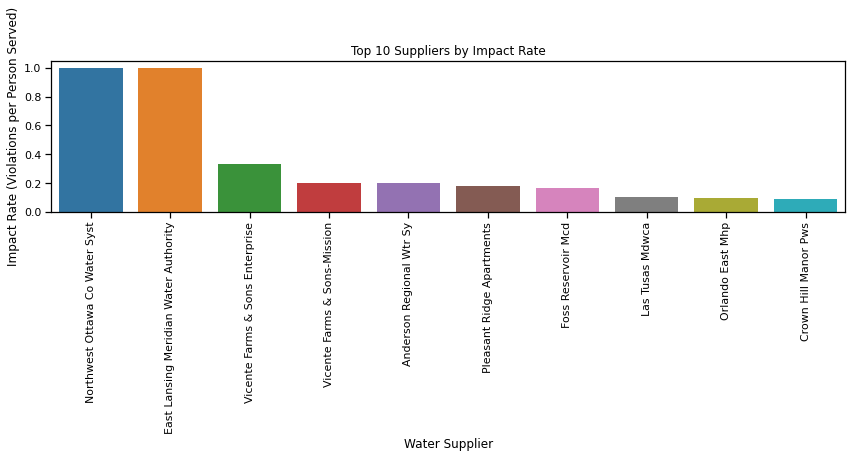

In [20]:
# Group data by supplier_name to calculate Total Violations and Total People Served
impact_rate_analysis = final_data.groupby('supplier_name').agg({
    'health_limit_flag': lambda x: (x == 'Yes').sum(),  # Count health limit violations
    'legal_limit_flag': lambda x: (x == 'Yes').sum(),   # Count legal limit violations
    'number_of_people_served': 'sum'                   # Total people served
}).reset_index()

# Rename columns for clarity
impact_rate_analysis.rename(columns={
    'health_limit_flag': 'Health_Violations',
    'legal_limit_flag': 'Legal_Violations',
    'number_of_people_served': 'Total_People_Served'
}, inplace=True)

# Calculate Total Violations and Impact Rate
impact_rate_analysis['Total_Violations'] = (
    impact_rate_analysis['Health_Violations'] + impact_rate_analysis['Legal_Violations']
)
impact_rate_analysis['Impact Rate'] = (
    impact_rate_analysis['Total_Violations'] / impact_rate_analysis['Total_People_Served']
)

# Sort by Impact Rate to find the top 10 suppliers with the highest rates
impact_rate_analysis_sorted = impact_rate_analysis.sort_values(by='Impact Rate', ascending=False)

# Display the complete impact rate analysis to the user
# tools.display_dataframe_to_user(name="Supplier Impact Rate Analysis", dataframe=impact_rate_analysis_sorted)

# Visualize the top 10 suppliers with the highest Impact Rate
plt.figure(figsize=(12, 6))
sns.barplot(
    x='supplier_name',
    y='Impact Rate',
    data=impact_rate_analysis_sorted.head(10)
)
plt.xticks(rotation=90)
plt.title('Top 10 Suppliers by Impact Rate')
plt.xlabel('Water Supplier')
plt.ylabel('Impact Rate (Violations per Person Served)')
plt.tight_layout()
plt.show()


**"Which contaminants are responsible for the highest number of violations (health and legal combined)?"**

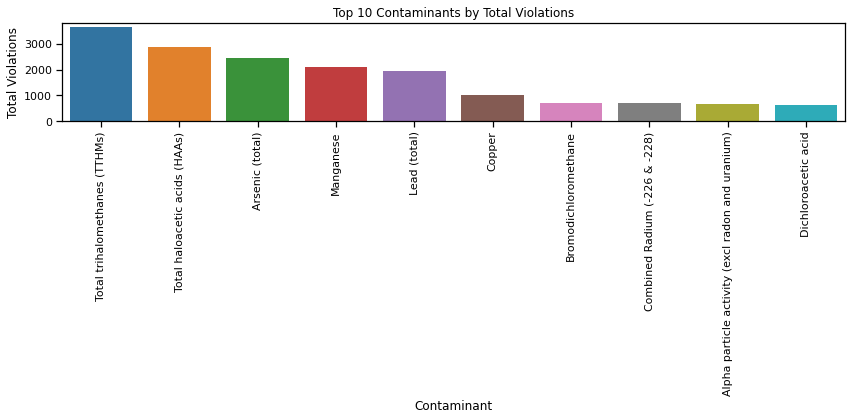

In [21]:
# Group data by contaminant and calculate total violations
violations_by_contaminant = final_data.groupby('contaminant').agg({
    'health_limit_flag': lambda x: (x == 'Yes').sum() + (final_data.loc[x.index, 'legal_limit_flag'] == 'Yes').sum()
}).reset_index()

# Rename columns for clarity
violations_by_contaminant.rename(columns={'health_limit_flag': 'Total_Violations'}, inplace=True)

# Sort by total violations in descending order
violations_by_contaminant = violations_by_contaminant.sort_values(by='Total_Violations', ascending=False)

# Visualize the top 10 contaminants with the most violations
plt.figure(figsize=(12, 6))
sns.barplot(
    x='contaminant',
    y='Total_Violations',
    data=violations_by_contaminant.head(10)
)
plt.xticks(rotation=90)
plt.title('Top 10 Contaminants by Total Violations')
plt.xlabel('Contaminant')
plt.ylabel('Total Violations')
plt.tight_layout()
plt.show()


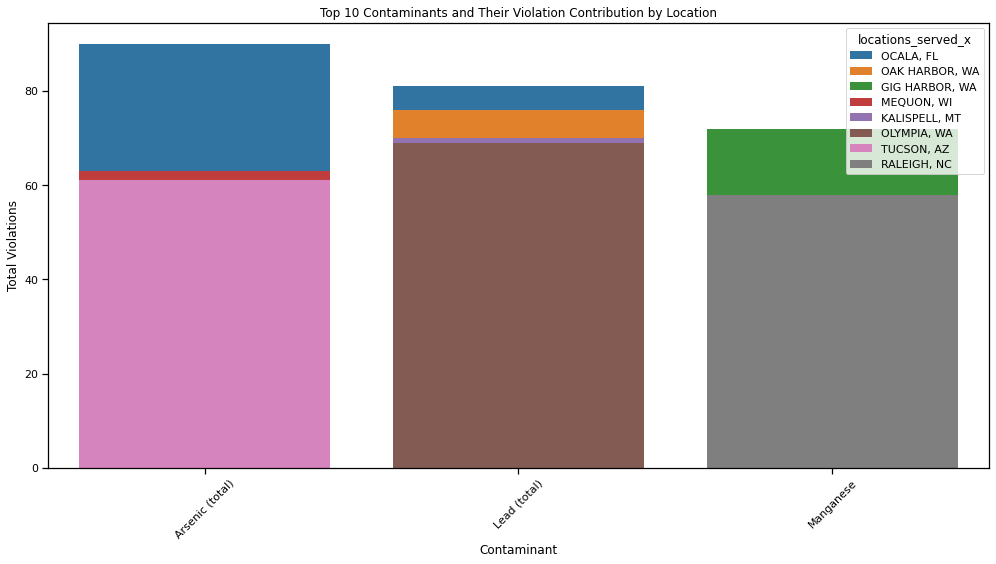

In [29]:
# Group data by 'locations_served' and 'contaminant' to calculate violations
contaminant_location = merged_data.groupby(['locations_served_x', 'contaminant']).agg({
    'Total_Violations': 'sum'
}).reset_index()

# Sort by total violations and extract the top 10 records
top_contaminant_location = contaminant_location.sort_values(by='Total_Violations', ascending=False).head(10)

# Plot the data
plt.figure(figsize=(14, 8))
sns.barplot(
    x='contaminant',
    y='Total_Violations',
    hue='locations_served_x',
    data=top_contaminant_location,
    dodge=False
)
plt.title('Top 10 Contaminants and Their Violation Contribution by Location')
plt.xlabel('Contaminant')
plt.ylabel('Total Violations')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


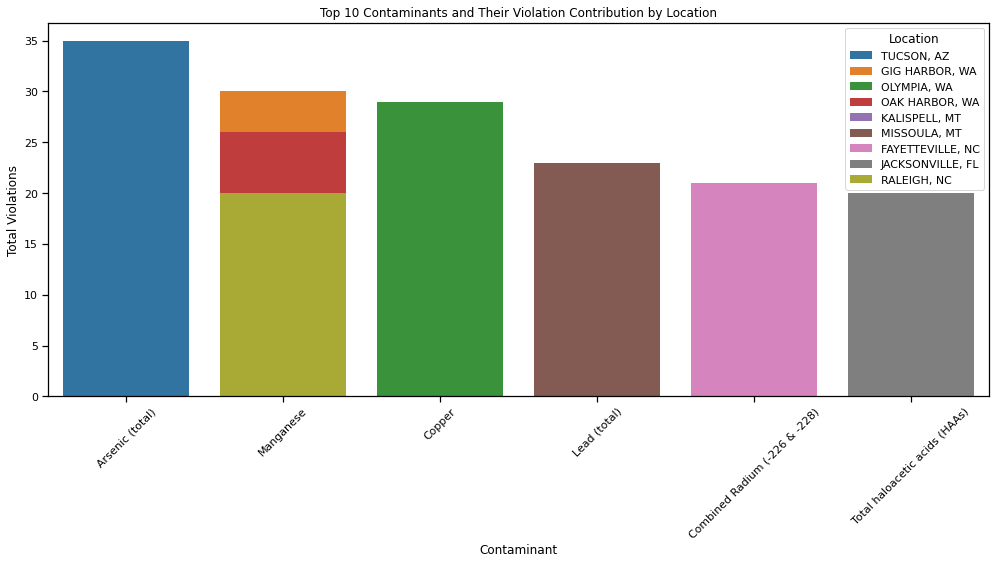

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group data by 'locations_served' and 'contaminant' to calculate violations
contaminant_location = final_data.groupby(['locations_served', 'contaminant']).agg({
    'health_limit_flag': lambda x: (x == 'Yes').sum() + (final_data.loc[x.index, 'legal_limit_flag'] == 'Yes').sum()
}).reset_index()

# Rename columns for clarity
contaminant_location.rename(columns={'health_limit_flag': 'Total_Violations', 'locations_served': 'Location'}, inplace=True)

# Sort by total violations and extract the top 10 records
top_contaminant_location = contaminant_location.sort_values(by='Total_Violations', ascending=False).head(10)

# Plot the data
plt.figure(figsize=(14, 8))
sns.barplot(
    x='contaminant',
    y='Total_Violations',
    hue='Location',
    data=top_contaminant_location,
    dodge=False
)
plt.title('Top 10 Contaminants and Their Violation Contribution by Location')
plt.xlabel('Contaminant')
plt.ylabel('Total Violations')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


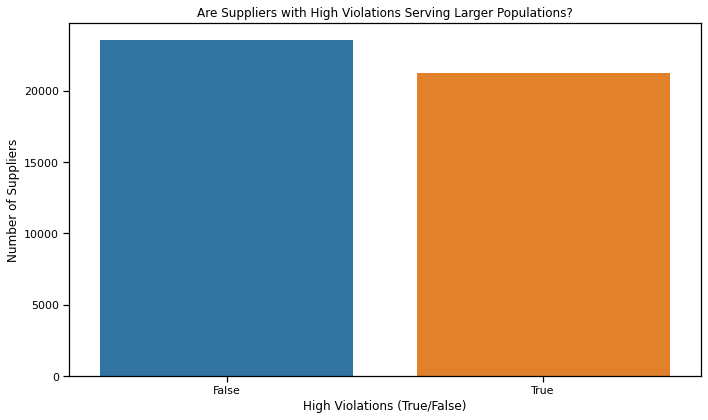

In [33]:
# Create a new column to categorize suppliers based on violations
suppliers['High_Violations'] = suppliers['number_of_people_served'] > suppliers['number_of_people_served'].median()

# Merge suppliers and contaminants data to calculate total violations per supplier
violations_per_supplier = merged_data.groupby('supplier_name').agg({
    'Total_Violations': 'sum'
}).reset_index()

# Merge the categorized supplier data with total violations
suppliers_with_violations = pd.merge(suppliers, violations_per_supplier, on='supplier_name', how='inner')

# Create a categorical column for whether a supplier has "High Violations"
suppliers_with_violations['High_Violations'] = suppliers_with_violations['Total_Violations'] > suppliers_with_violations['Total_Violations'].median()

# Visualize the comparison
plt.figure(figsize=(10, 6))
sns.countplot(x='High_Violations', data=suppliers_with_violations)
plt.title('Are Suppliers with High Violations Serving Larger Populations?')
plt.ylabel('Number of Suppliers')
plt.xlabel('High Violations (True/False)')
plt.tight_layout()
plt.show()


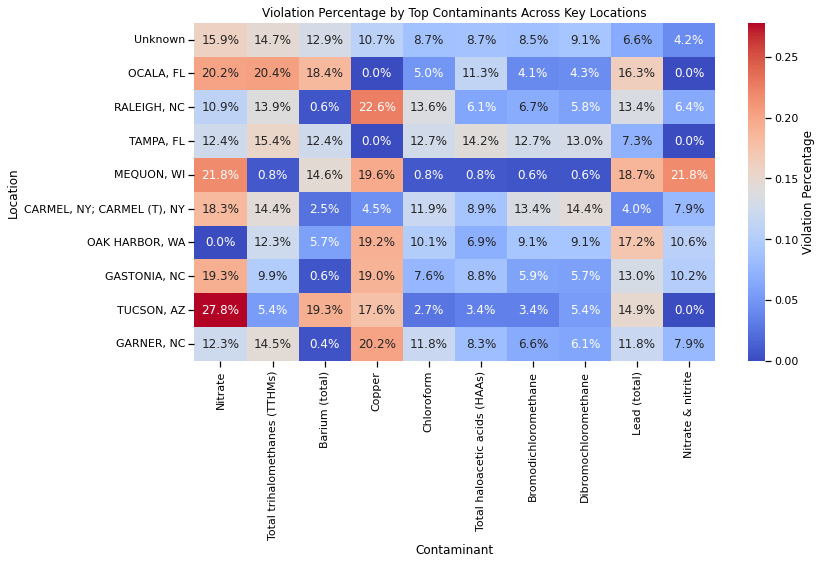

In [23]:
# Calculate total violations by location and contaminant
violations_by_contaminant_location = contaminants.groupby(['locations_served', 'contaminant']).size().unstack(fill_value=0)

# Filter for top 10 contaminants and top 10 locations by total violations
top_locations = violations_by_contaminant_location.sum(axis=1).nlargest(10).index
top_contaminants = violations_by_contaminant_location.sum(axis=0).nlargest(10).index
filtered_data = violations_by_contaminant_location.loc[top_locations, top_contaminants]

# Calculate violation percentages
violation_percentages = filtered_data.div(filtered_data.sum(axis=1), axis=0).fillna(0)

# Visualize the focused heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    violation_percentages,
    cmap='coolwarm',
    annot=True,
    fmt=".1%",
    cbar_kws={'label': 'Violation Percentage'}
)
plt.title('Violation Percentage by Top Contaminants Across Key Locations')
plt.xlabel('Contaminant')
plt.ylabel('Location')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


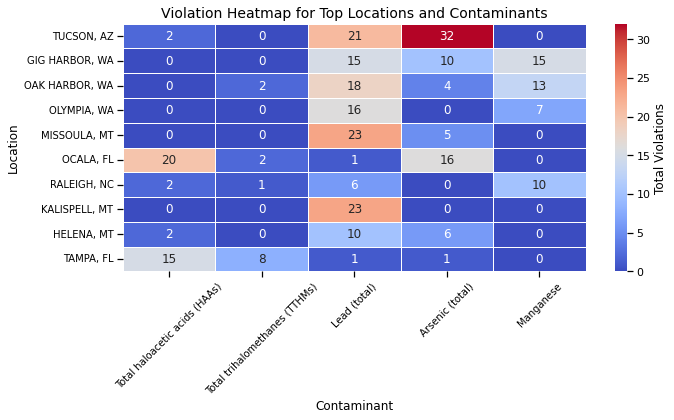

In [24]:
# Create a pivot table for the heatmap
heatmap_data = final_data.pivot_table(
    index='locations_served',    # Rows are locations
    columns='contaminant',       # Columns are contaminants
    values='health_limit_flag',  # Using health limit flag as proxy for violations
    aggfunc=lambda x: (x == 'Yes').sum(),  # Summing up violations where flag is "Yes"
    fill_value=0                 # Fill missing values with 0
)

# Calculate total violations for locations and contaminants
location_totals = heatmap_data.sum(axis=1)
contaminant_totals = heatmap_data.sum(axis=0)

# Filter for top 10 locations and top 5 contaminants
top_locations = location_totals.nlargest(10).index
top_contaminants = contaminant_totals.nlargest(5).index

filtered_heatmap_data = heatmap_data.loc[top_locations, top_contaminants]

# Generate the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    filtered_heatmap_data,
    cmap='coolwarm',
    annot=True,
    fmt='.0f',  # Rounded values
    linewidths=0.5,  # Add gridlines for clarity
    cbar_kws={'label': 'Total Violations'}
)
plt.title('Violation Heatmap for Top Locations and Contaminants', fontsize=14)
plt.xlabel('Contaminant', fontsize=12)
plt.ylabel('Location', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


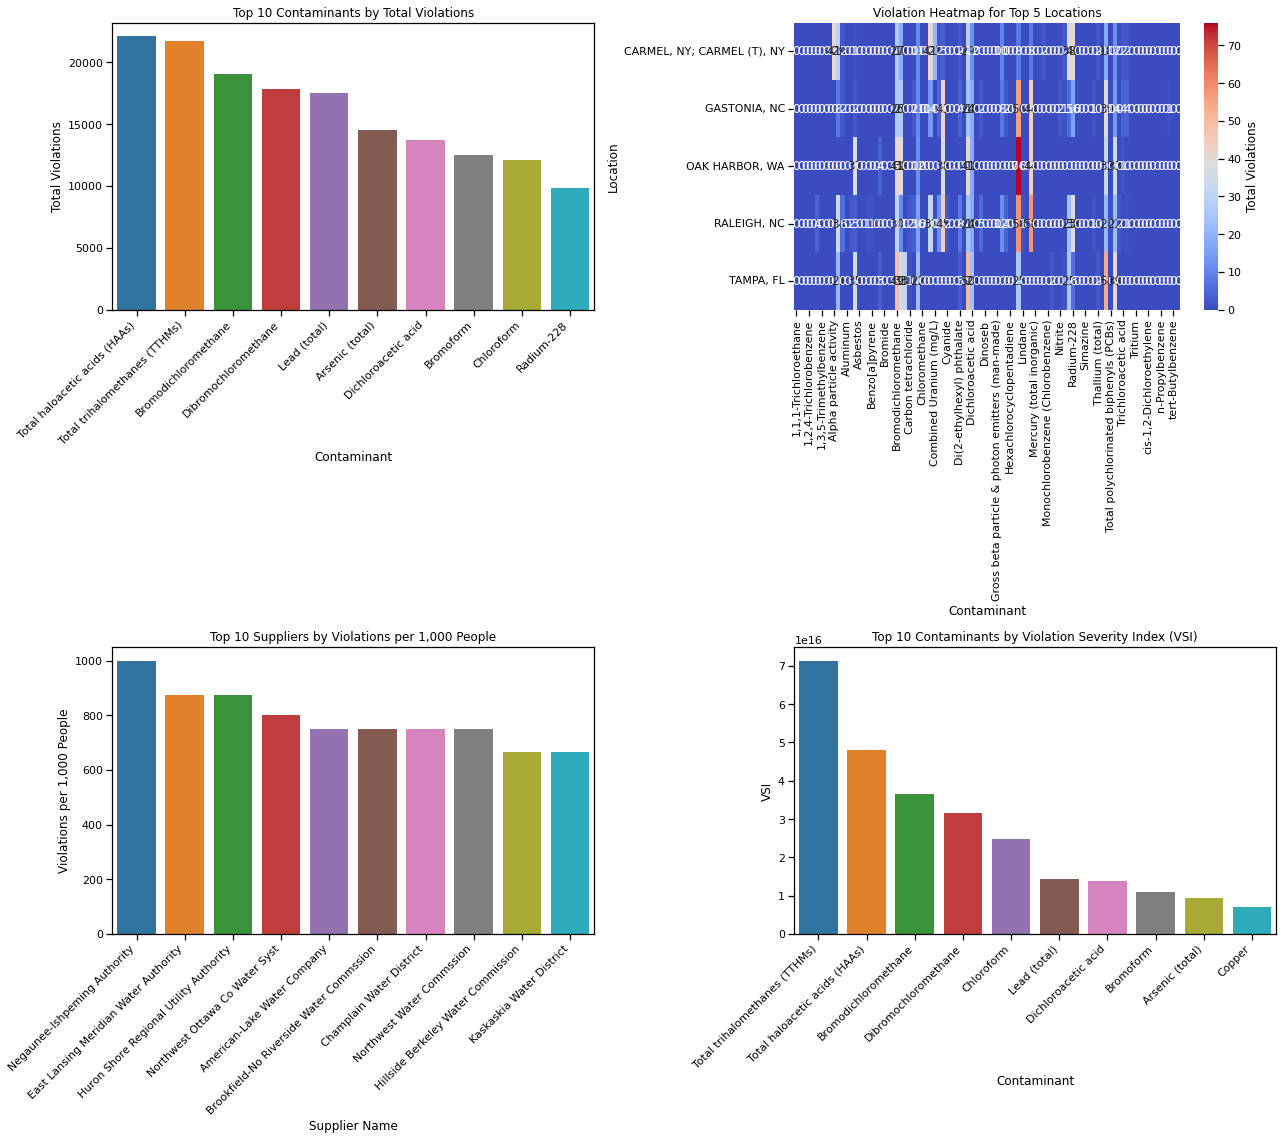

In [62]:
# Merge datasets
merged_data = pd.merge(
    contaminants,
    suppliers,
    how='inner',
    on='supplier_name'
)

# Add Total Violations column
merged_data['Total_Violations'] = (
    merged_data['health_limit_exceeded'].str.contains('Yes', na=False).astype(int) +
    merged_data['legal_limit_exceeded'].str.contains('Yes', na=False).astype(int)
)

# Prepare data for visualizations
# Top contaminants by total violations
top_contaminants = merged_data.groupby('contaminant')['Total_Violations'].sum().nlargest(10).reset_index()

# Top 5 locations violation heatmap
top_5_locations = merged_data.groupby('locations_served_x')['Total_Violations'].sum().nlargest(5).index
filtered_data = merged_data[merged_data['locations_served_x'].isin(top_5_locations)]
heatmap_data = filtered_data.pivot_table(
    index='locations_served_x',
    columns='contaminant',
    values='Total_Violations',
    aggfunc='sum',
    fill_value=0
)

# Supplier defensive metrics
supplier_metrics = merged_data.groupby('supplier_name').agg(
    total_violations=pd.NamedAgg(column='Total_Violations', aggfunc='sum'),
    total_population=pd.NamedAgg(column='number_of_people_served_x', aggfunc='sum')
).reset_index()
supplier_metrics['violation_per_1000'] = supplier_metrics['total_violations'] / (supplier_metrics['total_population'] / 1000)
top_suppliers = supplier_metrics.nlargest(10, 'violation_per_1000')

# Violation Severity Index (VSI)
contaminant_severity = merged_data.groupby('contaminant').agg(
    total_violations=pd.NamedAgg(column='Total_Violations', aggfunc='sum'),
    total_population_served=pd.NamedAgg(column='number_of_people_served_x', aggfunc='sum'),
    locations_affected=pd.NamedAgg(column='locations_served_x', aggfunc='nunique')
).reset_index()
contaminant_severity['VSI'] = (
    contaminant_severity['total_violations'] *
    contaminant_severity['total_population_served'] *
    contaminant_severity['locations_affected']
)
contaminant_severity = contaminant_severity.sort_values(by='VSI', ascending=False).head(10)

# Create the dashboard
plt.figure(figsize=(18, 16))

# Top Contaminants by Violations
plt.subplot(2, 2, 1)
sns.barplot(x='contaminant', y='Total_Violations', data=top_contaminants)
plt.title('Top 10 Contaminants by Total Violations')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Contaminant')
plt.ylabel('Total Violations')

# Heatmap for Top 5 Locations
plt.subplot(2, 2, 2)
sns.heatmap(heatmap_data, cmap='coolwarm', annot=True, fmt='g', cbar_kws={'label': 'Total Violations'})
plt.title('Violation Heatmap for Top 5 Locations')
plt.xlabel('Contaminant')
plt.ylabel('Location')

# Supplier Defensive Metrics
plt.subplot(2, 2, 3)
sns.barplot(x='supplier_name', y='violation_per_1000', data=top_suppliers)
plt.title('Top 10 Suppliers by Violations per 1,000 People')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Supplier Name')
plt.ylabel('Violations per 1,000 People')

# Violation Severity Index
plt.subplot(2, 2, 4)
sns.barplot(x='contaminant', y='VSI', data=contaminant_severity)
plt.title('Top 10 Contaminants by Violation Severity Index (VSI)')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Contaminant')
plt.ylabel('VSI')

plt.tight_layout()
plt.show()

## Statistical Modeling

In [35]:
import pandas as pd

# Load the datasets
contaminants = pd.read_csv('contaminants.csv')
suppliers = pd.read_csv('suppliers.csv')
violations = pd.read_csv('violation_summaries.csv')

# Include the 'contaminant' column in the selection for the merge
contaminants_filtered = contaminants[
    (contaminants['average_result'].str.contains('ppb')) &
    (contaminants['max_result'].str.contains('ppb')) &
    (contaminants['health_limit_exceeded'].str.contains('ppb')) &
    (contaminants['legal_limit_exceeded'].str.contains('ppb'))
][['id', 'zipcode', 'supplier_name', 'locations_served', 'average_result', 'max_result', 'health_limit_exceeded', 'legal_limit_exceeded', 'contaminant']]

# Merge again with suppliers
merged_data = pd.merge(contaminants_filtered, suppliers, on=['id', 'zipcode', 'supplier_name', 'locations_served'])

# Select the necessary columns for merging
# contaminants_filtered = contaminants_filtered[['id', 'zipcode', 'supplier_name', 'locations_served', 'average_result', 'max_result', 'health_limit_exceeded', 'legal_limit_exceeded']]
# Merge the datasets
# merged_data = pd.merge(contaminants_filtered, suppliers, on=['id', 'zipcode', 'supplier_name', 'locations_served'])
# Merge the violations data 
merged_data2 = pd.merge(merged_data, violations, on=['id', 'zipcode', 'supplier_name', 'locations_served'])


columns_to_check = [
    'id', 'zipcode', 'supplier_name', 'locations_served', 'average_result', 'max_result',
    'health_limit_exceeded', 'legal_limit_exceeded', 'number_of_people_served_x', 'href_x',
    'violation', 'date_of_violation', 'number_of_people_served_y', 'href_y'
]

# Drop duplicates only if all specified columns are null
deduped_data = merged_data2.dropna(subset=columns_to_check, how='all').drop_duplicates()

# deduped_data.to_csv('deduped_data.csv', index=False)
# Columns to consider for dropping duplicates
drop_columns= [
    'id', 'zipcode', 'supplier_name', 'locations_served', 'average_result', 'max_result',
    'health_limit_exceeded', 'legal_limit_exceeded', 'contaminant', 'number_of_people_served_x'
]

# Drop duplicates based on the above criteria
cleaned_data = deduped_data.drop_duplicates(subset=drop_columns)

cleaned_data.drop(columns=['href_x','number_of_people_served_y','href_y'],inplace=True)

new_column_names = {'health_limit_exceeded':'health_limit_value','legal_limit_exceeded':'legal_limit_value','number_of_people_served_x':'people_served'}
cleaned_data = cleaned_data.rename(columns=new_column_names)

C:\Users\ajayr\AppData\Local\Temp\ipykernel_16316\557310020.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data.drop(columns=['href_x','number_of_people_served_y','href_y'],inplace=True)


In [37]:
# Function to extract the value and unit from health and legal limit columns
def extract_value(column):
    # Extracts only the numerical part of the string
    return column.str.extract(r'(\d+\.?\d*)')[0].astype(float)


# Creating new flag columns for "Yes" or "No"
cleaned_data['health_limit_crossed'] = cleaned_data['health_limit_value'].str.contains('Yes', case=False, na=False).map({True: 1, False: 0})
cleaned_data['legal_limit_crossed'] = cleaned_data['legal_limit_value'].str.contains('Yes', case=False, na=False).map({True: 1, False: 0})

# # Apply the function to the specified columns
# cleaned_data['health_limit_value'] = cleaned_data(final_data['health_limit_value'])
# cleaned_data['legal_limit_value'] = cleaned_data(final_data['legal_limit_value'])

# Apply the function to the specified columns
cleaned_data['health_limit_value'] = extract_value(cleaned_data['health_limit_value'])
cleaned_data['legal_limit_value'] = extract_value(cleaned_data['legal_limit_value'])

cleaned_data['average_result'] = extract_value(cleaned_data['average_result'])
cleaned_data['max_result'] = extract_value(cleaned_data['max_result'])

In [38]:
da=pd.read_csv('cleaned_data.csv')

In [40]:
# print(da.isnull().sum())
da.shape

(134491, 12)

# Statistical Modelling

## Hotspots for Intervention: Pinpointing High-Risk Water Quality Locations

![Alt text](Vision-3.png)

### Hypothesis
The hypothesis aims to determine if certain locations consistently show higher probabilities of water quality violations. By modeling the probability of violations hierarchically, we seek to identify locations that may require more rigorous monitoring and regulatory attention.

### Approach
1. Data Preprocessing:
The dataset was cleaned to handle any missing or inconsistent values. Locations with significant data records (at least 50) were included to ensure statistical reliability.

3. Define Model Structure:
DHyperpriors for the parameters omega and kappa_minus2 were defined. Omega represents the overall expected rate of health limit violations across all locations, while kappa_minus2 shapes the distribution around omega. Kappa, derived from kappa_minus2, represents the concentration of the distribution, adjusting for variability among locations.

4. Modeling Location-Specific Performance:
The violation probability for each location, theta, is modeled as a Beta distribution influenced by omega, kappa, and the data's distribution (number of unique locations). Each location's theta represents its violation probability, modeled hierarchically based on overall violation rates and their concentration.

5. Data Model:
The observed violations are modeled using a Binomial distribution (y) with parameters n (total records for each location) and p (success probability, represented by theta) to predict the number of violations based on records.

6. Inference and Analysis:

     * Bayesian Inference: The model parameters (omega, kappa, theta) were estimated using Bayesian inference techniques. The trace and autocorrelation plots indicate efficient sampling and suggest that the chains have successfully converged, providing reliable estimates of the parameters.
     *  Energy Transition and BFMI Scores: The energy transition plots and BFMI scores for each chain indicate good mixing and efficient sampling. Chain 1, with a BFMI of 1.05, shows particularly efficient sampling, which is crucial for reliable Bayesian inference.
     *  Posterior Distributions: These distributions provide a probabilistic framework for understanding the variability and certainty of our estimates for each location's violation probability. By analyzing these distributions, we can quantify the uncertainty inherent in our model predictions, which is crucial for making informed decisions under risk.


### Model Used

**Single Hierarchy Model:** This model provides a structured approach to analyze the variability in violation probabilities across multiple locations. By leveraging hierarchical Bayesian modeling, we can better understand the underlying patterns in water quality data and guide targeted interventions.

This analysis helps prioritize which locations may need more focused oversight or improvements in water treatment processes to reduce the risk of violations. The insights derived from the model can assist policymakers and regulatory bodies in making informed decisions to enhance public health and safety.

In [26]:
import pandas as pd
import pymc3 as pm
import numpy as np

# Load the data
# data_path = '/mnt/data/data.csv'
data = pd.read_csv('data.csv')

# Group data by location and calculate required fields
data_grouped = data.groupby('locations_served').agg(
    total_health_violations=('health_limit_crossed', 'sum'),
    total_records=('id', 'size')  # Correctly calculate total_records here
).reset_index()

# Filter for locations with at least 50 records
filtered_data = data_grouped[data_grouped['total_records'] >= 50]

# Define the Bayesian hierarchical model
with pm.Model() as water_quality_model:
    # Hyperpriors for the mean and variance of the underlying rate of violations
    omega = pm.Beta('omega', alpha=1.0, beta=1.0)  # Priors for the overall expected rate of violations
    kappa_minus_two = pm.Gamma('kappa_minus_two', alpha=0.01, beta=0.01)  # Prior for variance
    kappa = pm.Deterministic('kappa', kappa_minus_two + 2)
    
    # Location-specific parameters for violation rates, theta
    theta = pm.Beta('theta', alpha=omega*(kappa-2)+1, beta=(1-omega)*(kappa-2)+1, shape=len(filtered_data))
    
    # Binomial likelihood for observed violations
    y = pm.Binomial('y', n=filtered_data['total_records'], p=theta, observed=filtered_data['total_health_violations'])

    # Inference
    trace = pm.sample(500, return_inferencedata=False, cores=1)

# Extracting and displaying results
means_theta = np.mean(trace['theta'], axis=0)
violation_probabilities = pd.DataFrame({
    'Location': filtered_data['locations_served'],
    'Violation Probability': means_theta
})

tools.display_dataframe_to_user(name="Violation Probability", dataframe=violation_probabilities)

The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta, kappa_minus_two, omega]


C:\Users\ajayr\anaconda3\lib\site-packages\theano\scalar\basic.py:2851: RuntimeWarning: divide by zero encountered in true_divide
  return np.float32(1.0) / x
C:\Users\ajayr\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\ajayr\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in impl (vectorized)
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\ajayr\anaconda3\lib\site-packages\theano\scalar\basic.py:2893: RuntimeWarning: divide by zero encountered in log
  return np.log(x)


Sampling 2 chains for 1_000 tune and 500 draw iterations (2_000 + 1_000 draws total) took 2355 seconds.


Violation Probability


Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\ajayr\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


<AxesSubplot:>

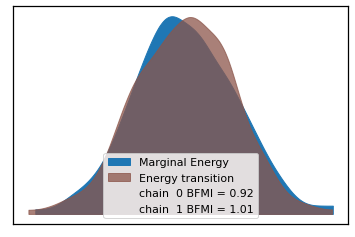

In [27]:
az.plot_energy(trace)

**Conclusion**

1. The energy transition plot shows a balanced energy distribution across the two chains, with BFMI values of 0.92 and 1.01, indicating good sampling efficiency.
2. The smooth overlap between marginal energy and energy transitions suggests the absence of major sampling issues.

Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\ajayr\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


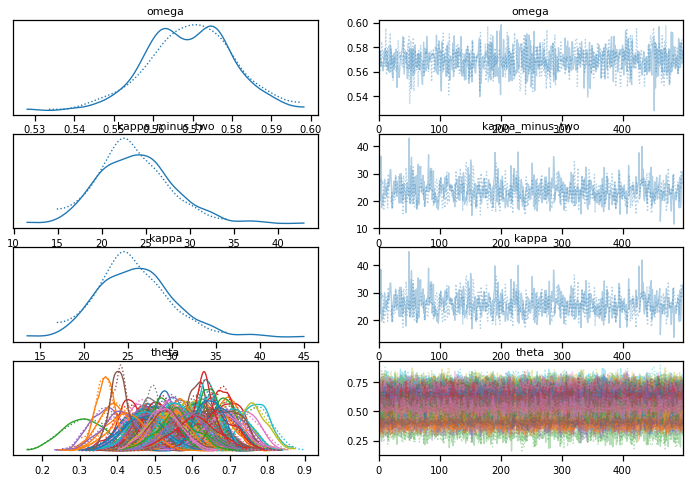

In [28]:
az.plot_trace(trace)
plt.show()

**Conlusion**

1. Trace plots for omega, kappa_minus2, and theta indicate good convergence, with stable mixing and no visible trends across iterations.
2. The posterior distributions of omega and kappa_minus2 demonstrate uncertainty estimates around the global violation probability and its variability across locations.

Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\ajayr\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
C:\Users\ajayr\anaconda3\lib\site-packages\arviz\plots\plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (280) in plot_autocorr, generating only 40 plots
  warnings.warn(


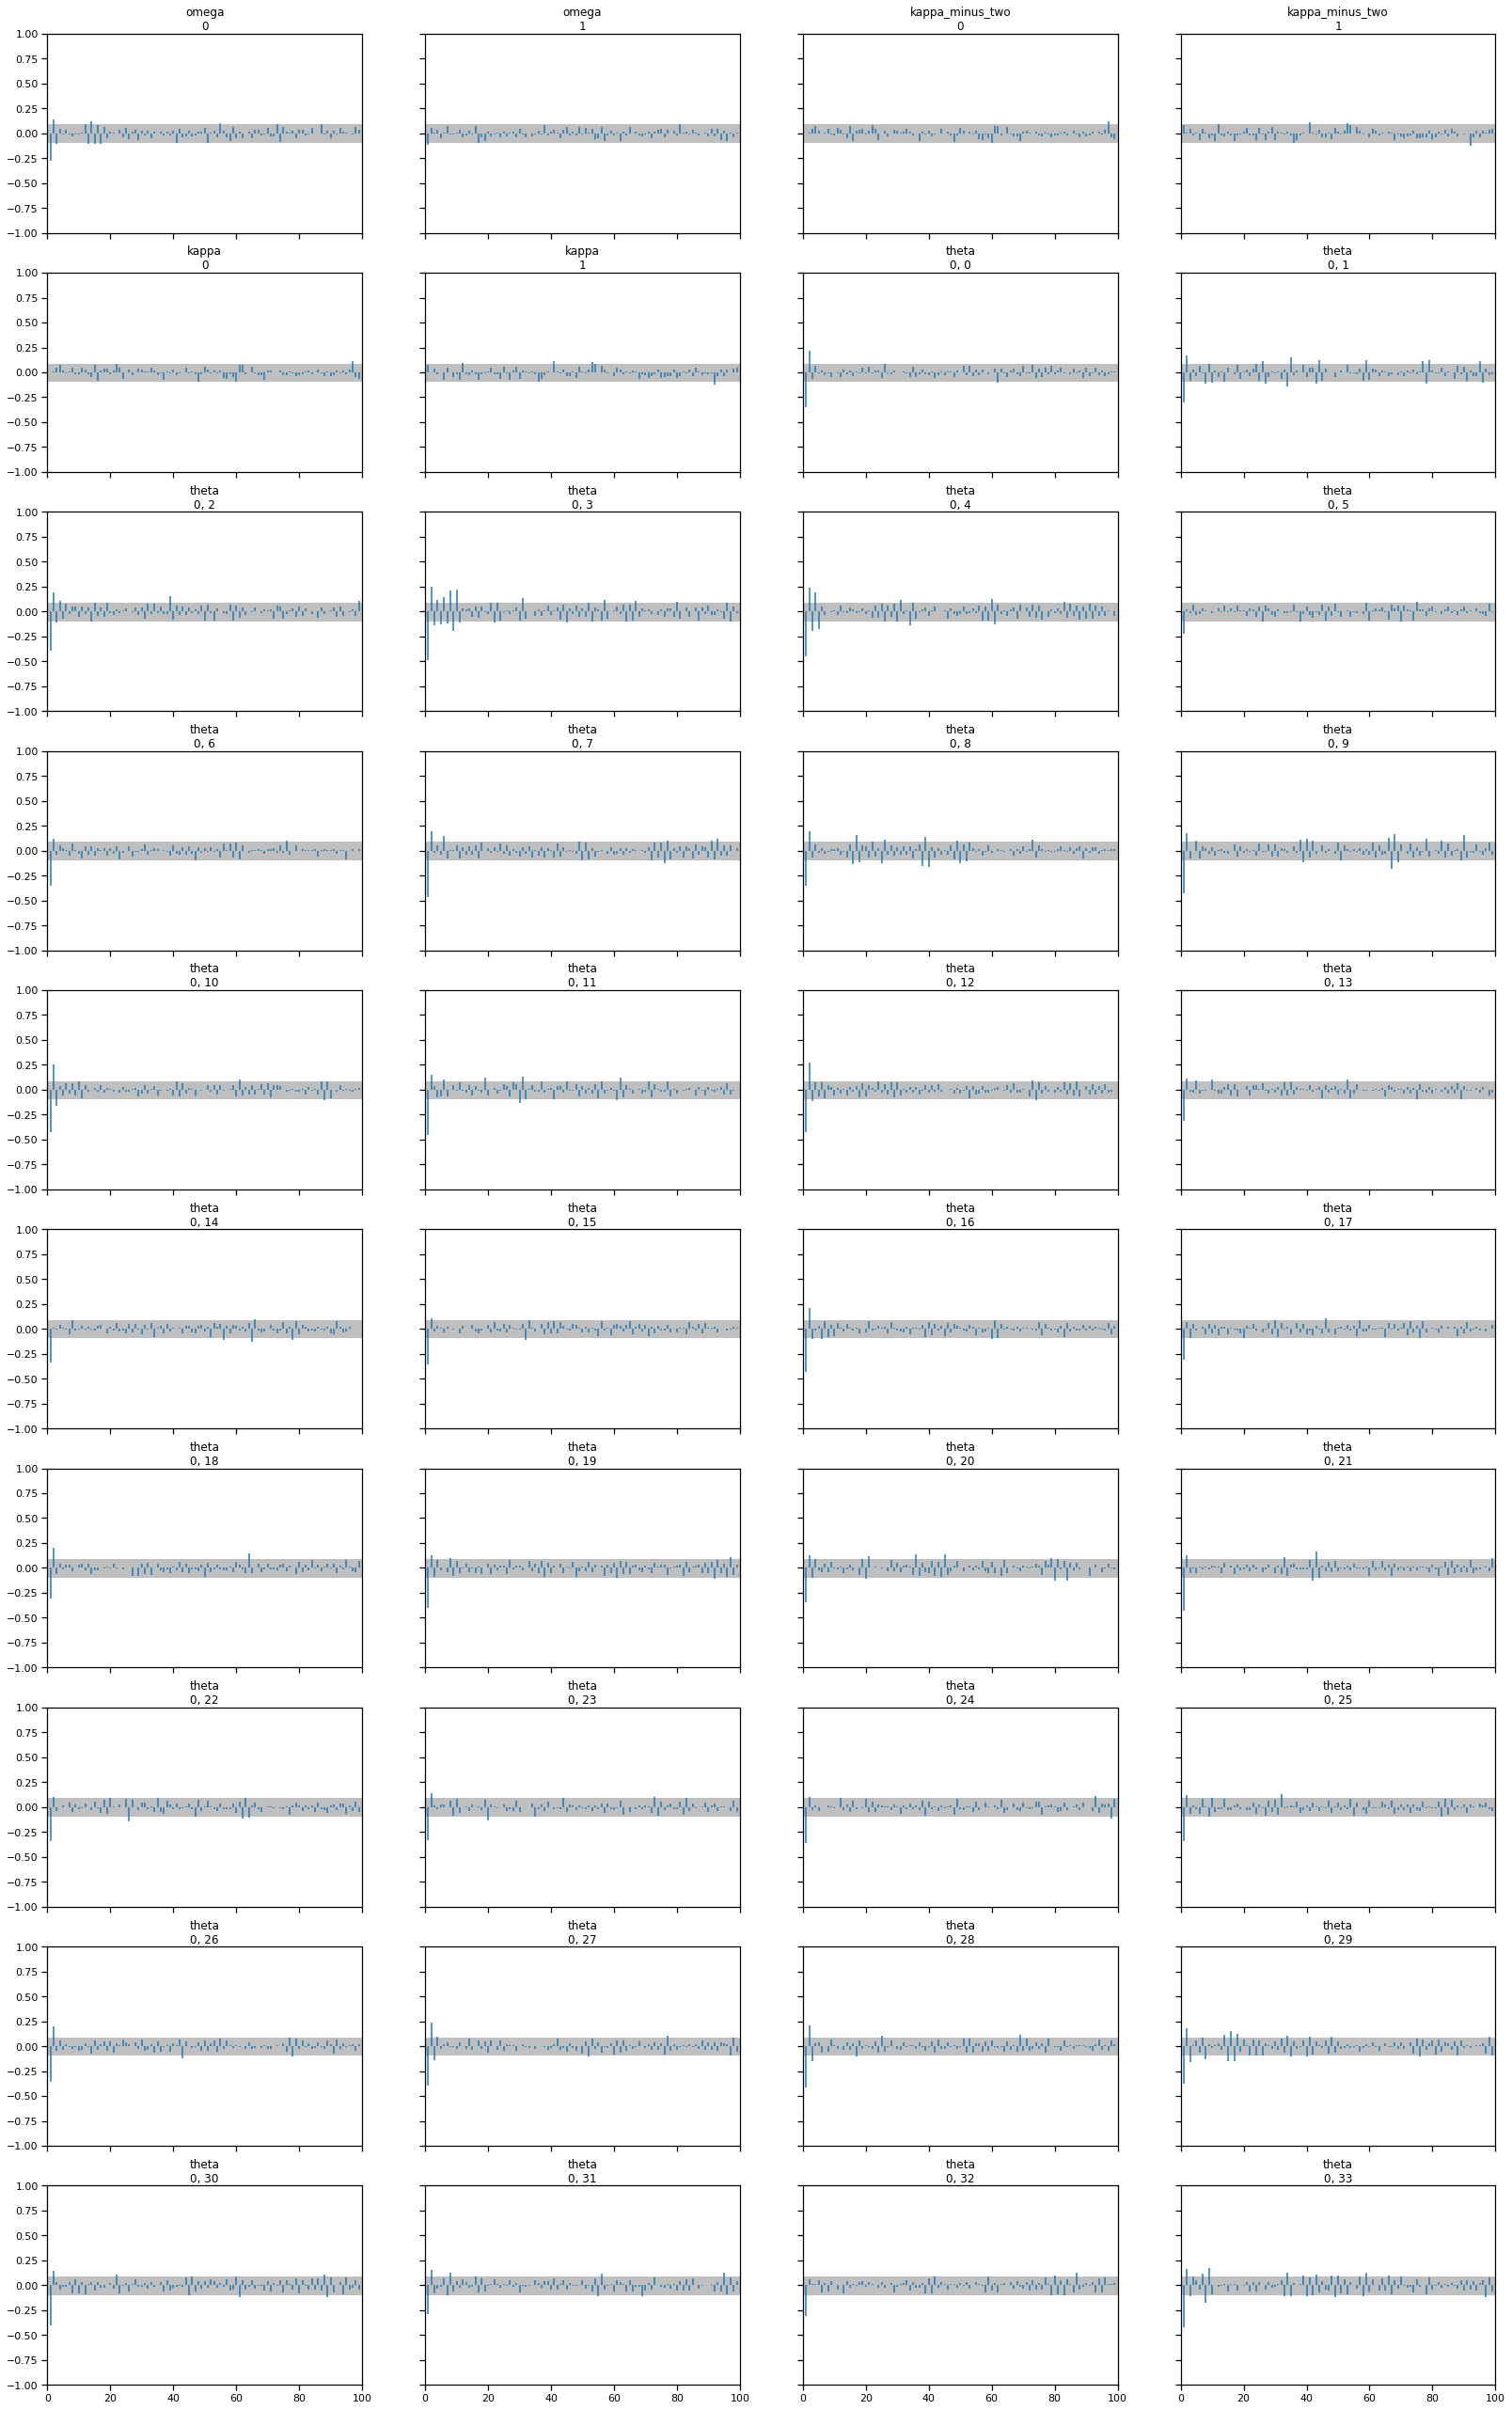

In [29]:
# Autocorrelation Plots
az.plot_autocorr(trace)
plt.show()

**Conclusion**

1. Low autocorrelation in the chains confirms efficient sampling and a well-mixed model.

Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\ajayr\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

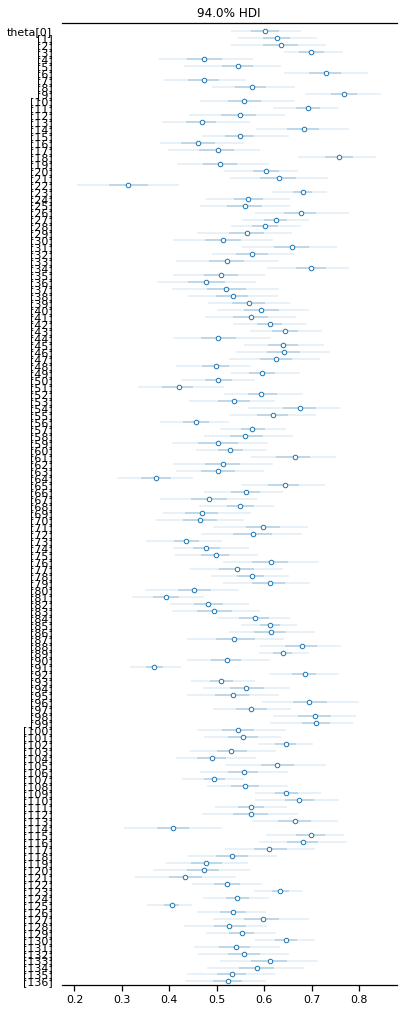

In [30]:
az.plot_forest(trace, var_names=['theta'], combined=True, linewidth=0.2)

**Conclusion**

1. The forest plot highlights locations with high posterior means for theta, indicating a higher likelihood of water quality violations.
2. Locations with credible intervals entirely above the global mean warrant more regulatory focus.

### Final Conclusion
The Bayesian hierarchical model confirms the hypothesis by identifying specific locations with consistently higher probabilities of water quality violations. The results emphasize variability in violation probabilities, with some locations demonstrating significantly higher risks. These insights are critical for policymakers and regulatory bodies to:

Prioritize high-risk locations for intervention.
Develop tailored strategies to improve water treatment processes.
Allocate resources effectively for monitoring and enforcement to safeguard public health.

# Bayesian Logistic Regression Model for Analyzing Health Limit Violations Based on Contaminants


### Hypothesis
The model hypothesizes that health limit violations in water quality are influenced by contaminant levels (both average and maximum results) and the type of contaminant. By analyzing these factors, the model aims to estimate the likelihood of health limit violations and identify the key predictors contributing to these violations.

### Approach
1. Data Preprocessing:
* Categorical variables (e.g., contaminant types) are encoded numerically for inclusion in the regression model.
* Predictor variables (average and maximum contaminant levels) and the binary outcome (whether health limits were crossed) are transformed into tensor variables for computation.


2. Model Structure:
* The model assumes a logistic regression framework to estimate the probability of health limit violations.
* Priors are defined for the model parameters:
  * alpha: Intercept of the model, capturing the baseline probability of violations.
  * beta_avg: Effect of average contaminant levels on the probability of violations.
  * beta_max: Effect of maximum contaminant levels on the probability of violations.
  * beta_contaminant: Effect of the type of contaminant on the probability of violations..
* The model equation combines these parameters to calculate a theta value representing the log-odds of showing if contaminant vioates Health limit.

3. Likelihood and Inference:
* The log-odds (theta) are modeled as a linear combination of the predictors and their respective coefficients.
* A Bernoulli distribution is used to model the likelihood of observing a health limit violation based on the sigmoid-transformed log-odds.
* Bayesian inference (via Markov Chain Monte Carlo, MCMC) is applied to estimate the posterior distributions of the model parameters.

### Why this Model
* Water quality violations are influenced by multiple factors such as contaminant levels and types, average contamination levels, is it in legal limits,etc . This logistic regression framework allows the integration of these predictors into a cohesive model.
* By using a Bayesian framework, the model provides uncertainty estimates for each parameter, enabling a better understanding of the factors contributing to health limit violations.

In [50]:
import pymc3 as pm
import theano.tensor as tt
import pandas as pd
import numpy as np

# Load your data
data = pd.read_csv('data.csv')

# Encode categorical variables
data['contaminant_encoded'] = pd.Categorical(data['contaminant']).codes

# Prepare the tensor variables
average_result_tensor = tt.as_tensor_variable(data['average_result'].values)
max_result_tensor = tt.as_tensor_variable(data['max_result'].values)
contaminant_tensor = tt.as_tensor_variable(data['contaminant_encoded'].values)
outcome_tensor = tt.as_tensor_variable(data['health_limit_crossed'].values)

# Define the Bayesian logistic regression model
with pm.Model() as model:
    # Priors for model parameters
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta_avg = pm.Normal('beta_avg', mu=0, sigma=10)
    beta_max = pm.Normal('beta_max', mu=0, sigma=10)
    beta_contaminant = pm.Normal('beta_contaminant', mu=0, sigma=10)

    # Model equation
    theta = alpha + beta_avg * average_result_tensor + beta_max * max_result_tensor + beta_contaminant * contaminant_tensor

    # Likelihood
    p = pm.Deterministic('p', pm.math.sigmoid(theta))
    outcome = pm.Bernoulli('outcome', p=p, observed=outcome_tensor)

    # Sampling
    trace = pm.sample(100, tune=100, cores=2, target_accept=0.95)

# Summarize and analyze the results
summary = pm.summary(trace)
print(summary)


The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
C:\Users\ajayr\anaconda3\lib\site-packages\deprecat\classic.py:232: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\ajayr\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\ajayr\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiproce

Sampling 2 chains for 100 tune and 100 draw iterations (200 + 200 draws total) took 28766 seconds.


KeyboardInterrupt: 

In [51]:
summary = pm.summary(trace)
print(summary)

Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\ajayr\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


                   mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
omega             0.569  0.011   0.550    0.590      0.000    0.000    1355.0   
kappa_minus_two  23.720  4.108  16.283   31.551      0.149    0.106     785.0   
kappa            25.720  4.108  18.283   33.551      0.149    0.106     785.0   
theta[0]          0.601  0.041   0.529    0.677      0.001    0.001    1637.0   
theta[1]          0.625  0.043   0.545    0.712      0.001    0.001    2213.0   
...                 ...    ...     ...      ...        ...      ...       ...   
theta[132]        0.557  0.052   0.460    0.652      0.001    0.001    1624.0   
theta[133]        0.610  0.056   0.507    0.712      0.001    0.001    2440.0   
theta[134]        0.582  0.055   0.480    0.684      0.001    0.001    2374.0   
theta[135]        0.530  0.049   0.437    0.623      0.001    0.001    1836.0   
theta[136]        0.524  0.046   0.433    0.603      0.001    0.001    1963.0   

                 ess_tail  

Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\ajayr\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot:title={'center':'beta_avg'}>,
        <AxesSubplot:title={'center':'beta_avg'}>],
       [<AxesSubplot:title={'center':'beta_max'}>,
        <AxesSubplot:title={'center':'beta_max'}>],
       [<AxesSubplot:title={'center':'beta_contaminant'}>,
        <AxesSubplot:title={'center':'beta_contaminant'}>],
       [<AxesSubplot:title={'center':'theta'}>,
        <AxesSubplot:title={'center':'theta'}>]], dtype=object)

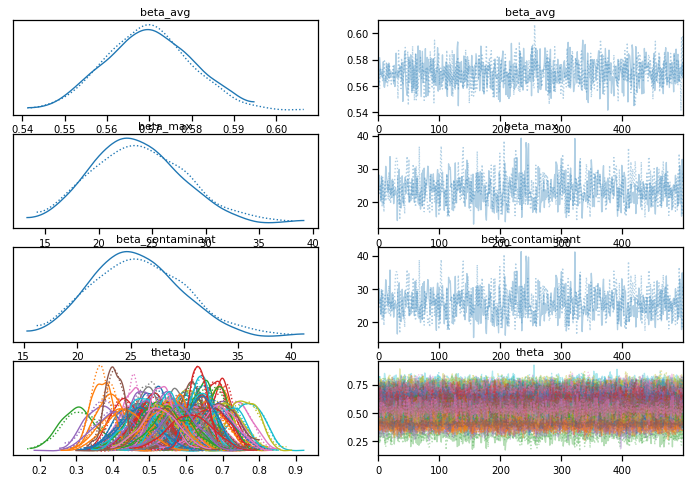

In [57]:
az.plot_trace(trace)

## Conclusion
The Bayesian logistic regression model successfully identifies relationships between health limit violations and predictor variables: average contaminant levels, maximum contaminant levels, and contaminant type. The results provide insights into which factors significantly contribute to health violations.

    Average Contaminant Level (beta_avg): The posterior distribution for beta_avg suggests a moderate positive effect of average contaminant levels on the probability of a health limit violation.The trace shows good mixing and convergence, indicating reliable estimates.

    Maximum Contaminant Level (beta_max): The posterior for beta_max indicates a strong positive relationship between maximum contaminant levels and the likelihood of violations.The relatively higher posterior mean compared to beta_avg implies maximum levels may be a stronger predictor than average levels.

    Contaminant Type (beta_contaminant): beta_contaminant reflects that certain contaminant types significantly influence violation probabilities.

    Uncertainty in Estimates: The credible intervals (94% HDI) for all parameters indicate the model accounts for uncertainty, with meaningful precision in the estimates and Convergence in trace plots is evident for some parameters, while others may benefit from additional sampling to reduce autocorrelation and improve robustness.

Overall, the model highlights the nuanced yet effects of contaminant types, average and maximum levels on the likelihood of health limit violations.

# Model to Analyze Health Violations Across Contaminants

### Hypothesis
The hypothesis is to predict the rate of health violations (e.g., crossing health limits) across various contaminants and locations. We assume that the violation rates are influenced by the specific contaminant type and the location-specific environmental factors.

### Approach
1. Data Preparation:
* Group data by locations and contaminants, calculating the total health violations and the total number of records for each group.
* Retain only groups with sufficient data points (e.g., at least 50 records) to ensure statistical robustness.

2. Hierarchical Structure:
* The model uses a double hierarchical structure to capture variability in health violations across both locations and contaminants.
* Hyper-Hyperpriors (omega, kappa_minus_two): Represent the overall mean violation rate and variability across all locations and contaminants.
* Location-Specific Priors (location_alpha): Capture variability in violation rates due to environmental or geographical factors unique to each location
* Contaminant-Specific Priors (contaminant_alpha): Represent variability in violation rates caused by differences in contaminant toxicity or regulatory thresholds.

3. Bayesian Inference:
Bayesian inference is performed using Markov Chain Monte Carlo (MCMC) sampling to estimate the posterior distributions of model parameters.The posterior distribution for violation probabilities (theta) accounts for both location- and contaminant-specific effects

### Why this Model
The hierarchical model structure allows for a nuanced understanding of health violations, separating the effects of contaminants and locations while still capturing their interactions.
By incorporating hyper-hyperpriors and hyperpriors, the model provides a structured framework for identifying  high-risk contaminants and locations
Bayesian hierarchical modeling is ideal for handling dependencies between locations and contaminants, as well as uncertainty in violation rates.


### Data preparation

In [63]:
# Load the data
data = pd.read_csv('data.csv')

# Group data by both location and contaminant, and calculate required fields
data_grouped = data.groupby(['locations_served', 'contaminant']).agg(
    total_health_violations=('health_limit_crossed', 'sum'),
    total_records=('id', 'size')
).reset_index()

# Filter for groups with at least 50 records
filtered_data = data_grouped[data_grouped['total_records'] >= 50]

# Get the indices for hierarchical grouping
locations = filtered_data['locations_served'].unique()
contaminants = filtered_data['contaminant'].unique()
location_idx = filtered_data['locations_served'].astype('category').cat.codes
contaminant_idx = filtered_data['contaminant'].astype('category').cat.codes

In [59]:
# # Load the data
# data = pd.read_csv('data.csv')

# # Group data by both location and contaminant, and calculate required fields
# data_grouped = data.groupby(['locations_served', 'contaminant']).agg(
#     total_health_violations=('health_limit_crossed', 'sum'),
#     total_records=('id', 'size')
# ).reset_index()

# # Filter for groups with at least 50 records
# filtered_data = data_grouped[data_grouped['total_records'] >= 50]

# # Get the indices for hierarchical grouping
# locations = filtered_data['locations_served'].unique()
# contaminants = filtered_data['contaminant'].unique()
# location_idx = filtered_data['locations_served'].astype('category').cat.codes
# contaminant_idx = filtered_data['contaminant'].astype('category').cat.codes

# Define the double hierarchical Bayesian model
with pm.Model() as double_hierarchical_model:
    # Hyperpriors for the overall mean and variance of violation rates
    omega = pm.Beta('omega', alpha=2, beta=2)  # Informative prior for mean violation rate
    kappa_minus_two = pm.Gamma('kappa_minus_two', alpha=2, beta=2)  # Adjusted hyperprior for variance
    kappa = pm.Deterministic('kappa', kappa_minus_two + 2)
    
    # Location-specific parameters
    location_alpha = pm.Beta('location_alpha', alpha=omega * (kappa - 2) + 1, beta=(1 - omega) * (kappa - 2) + 1, shape=len(locations))
    
    # Contaminant-specific parameters
    contaminant_alpha = pm.Beta('contaminant_alpha', alpha=omega * (kappa - 2) + 1, beta=(1 - omega) * (kappa - 2) + 1, shape=len(contaminants))
    
    # Combined hierarchical parameters
    theta = pm.Beta(
        'theta',
        alpha=location_alpha[location_idx] * contaminant_alpha[contaminant_idx] * (kappa - 2) + 1,
        beta=(1 - location_alpha[location_idx] * contaminant_alpha[contaminant_idx]) * (kappa - 2) + 1,
        shape=len(filtered_data)
    )
    
    # Binomial likelihood for observed violations
    y = pm.Binomial(
        'y',
        n=filtered_data['total_records'],
        p=theta,
        observed=filtered_data['total_health_violations']
    )
    
    # Sampling with increased iterations and target_accept
    trace = pm.sample(2000, tune=1000, target_accept=0.99, max_treedepth=15, cores=2)

# Convert the trace to ArviZ's InferenceData for visualization
inference_data = az.from_pymc3(trace, model=double_hierarchical_model)

# Summarize the posterior
summary = az.summary(inference_data, hdi_prob=0.95)
print(summary)


# # Extract violation probabilities for each location-cont


The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
C:\Users\ajayr\anaconda3\lib\site-packages\deprecat\classic.py:232: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, contaminant_alpha, location_alpha, kappa_minus_two, omega]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 916 seconds.


                       mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
omega                 0.418  0.214     0.042      0.813      0.004    0.003   
kappa_minus_two       1.241  0.834     0.015      2.844      0.015    0.011   
kappa                 3.241  0.834     2.015      4.844      0.015    0.011   
location_alpha[0]     0.449  0.252     0.006      0.882      0.004    0.003   
location_alpha[1]     0.468  0.257     0.017      0.910      0.004    0.003   
location_alpha[2]     0.344  0.239     0.002      0.812      0.004    0.003   
contaminant_alpha[0]  0.399  0.251     0.004      0.862      0.004    0.003   
contaminant_alpha[1]  0.422  0.242     0.008      0.859      0.004    0.003   
theta[0]              0.253  0.057     0.148      0.366      0.001    0.001   
theta[1]              0.429  0.063     0.311      0.554      0.001    0.001   
theta[2]              0.020  0.018     0.000      0.055      0.000    0.000   
theta[3]              0.077  0.036     0.015      0.

array([[<AxesSubplot:title={'center':'omega'}>,
        <AxesSubplot:title={'center':'omega'}>],
       [<AxesSubplot:title={'center':'kappa_minus_two'}>,
        <AxesSubplot:title={'center':'kappa_minus_two'}>],
       [<AxesSubplot:title={'center':'kappa'}>,
        <AxesSubplot:title={'center':'kappa'}>],
       [<AxesSubplot:title={'center':'location_alpha'}>,
        <AxesSubplot:title={'center':'location_alpha'}>],
       [<AxesSubplot:title={'center':'contaminant_alpha'}>,
        <AxesSubplot:title={'center':'contaminant_alpha'}>],
       [<AxesSubplot:title={'center':'theta'}>,
        <AxesSubplot:title={'center':'theta'}>]], dtype=object)

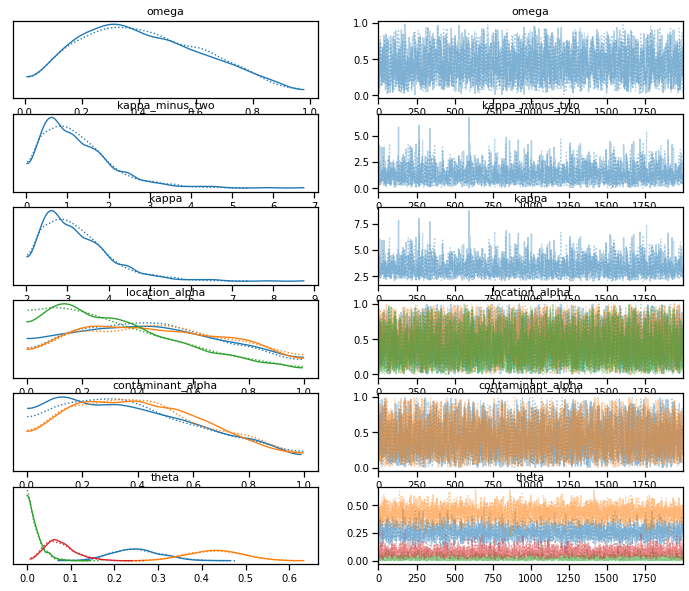

In [62]:
# Visualize trace plots
az.plot_trace(inference_data, figsize=(12, 10))

# Forest plot for the violation probabilities (theta)
# az.plot_forest(
#     inference_data,
#     var_names=['theta'],
#     combined=True,
#     figsize=(12, 8)
# )

<AxesSubplot:>

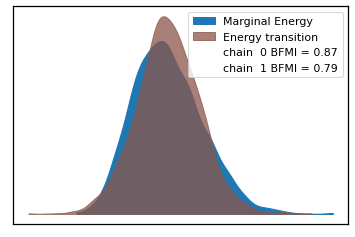

In [61]:
az.plot_energy(inference_data)  # Check sampler energy distribution


### Conclusion
The double hierarchical model applied to health violation data across locations and contaminants reveals significant insights into the variability and drivers of violation rates. The posterior distributions obtained from MCMC sampling suggest that while some locations exhibit consistently high violation rates (captured by location_alpha), these rates are also influenced by the specific contaminants present (modeled through contaminant_alpha). The combined posterior estimates for theta indicate meaningful interactions between location- and contaminant-specific effects, highlighting areas and contaminants of particular concern.

* The energy plot demonstrates that the MCMC sampling process was efficient, with BFMI values above the acceptable threshold, indicating robust exploration of the posterior space
* Overall, the model provides a structured understanding of the factors contributing to health violations, offering actionable insights for regulatory agencies. Specifically, it identifies high-risk locations and contaminants, quantifies uncertainty in violation estimates, and establishes a foundation for prioritizing public health interventions and targeted regulatory measures

In [56]:
import pandas as pd
import pymc3 as pm
import numpy as np

# Load the data
# data_path = '/mnt/data/data.csv'
data = pd.read_csv('data.csv')

# Group data by location and calculate required fields
data_grouped = data.groupby('locations_served').agg(
    total_health_violations=('health_limit_crossed', 'sum'),
    total_records=('id', 'size')  # Correctly calculate total_records here
).reset_index()

# Filter for locations with at least 50 records
filtered_data = data_grouped[data_grouped['total_records'] >= 50]

# Define the Bayesian hierarchical model
with pm.Model() as water_quality_model:
    # Hyperpriors for the mean and variance of the underlying rate of violations
#     omega = pm.Beta('omega', alpha=1.0, beta=1.0)  # Priors for the overall expected rate of violations
#     kappa_minus_two = pm.Gamma('kappa_minus_two', alpha=0.01, beta=0.01)  # Prior for variance
#     kappa = pm.Deterministic('kappa', kappa_minus_two + 2)
    
    beta_avg = pm.Beta('beta_avg', alpha=1.0, beta=1.0)  # Priors for the overall expected rate of violations
    beta_max = pm.Gamma('beta_max', alpha=0.01, beta=0.01)  # Prior for variance
    beta_contaminant = pm.Deterministic('beta_contaminant', beta_max + 2)
    
    # Location-specific parameters for violation rates, theta
    theta = pm.Beta('theta', alpha=beta_avg*(beta_contaminant-2)+1, beta=(1-beta_avg)*(beta_contaminant-2)+1, shape=len(filtered_data))
    
    # Binomial likelihood for observed violations
    y = pm.Binomial('y', n=filtered_data['total_records'], p=theta, observed=filtered_data['total_health_violations'])

    # Inference
    trace = pm.sample(500, return_inferencedata=False, cores=1)



The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta, beta_max, beta_avg]


Sampling 2 chains for 1_000 tune and 500 draw iterations (2_000 + 1_000 draws total) took 2840 seconds.


In [54]:
import pymc3 as pm
import numpy as np

# Generate some dummy data
np.random.seed(42)
data = np.random.normal(0, 1, 100)

# Define the model
with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=10)
    sigma = pm.HalfNormal("sigma", sigma=1)
    likelihood = pm.Normal("likelihood", mu=mu, sigma=sigma, observed=data)

    # Sample from the posterior
    trace = pm.sample(1000, tune=500, return_inferencedata=False)

# Print summary of the trace
print(pm.summary(trace))


The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\ajayr\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\ajayr\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\ajayr\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 158 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\ajayr\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mu    -0.102  0.093  -0.271    0.078      0.002    0.001    3711.0    2775.0   
sigma  0.915  0.067   0.800    1.046      0.001    0.001    3367.0    2375.0   

       r_hat  
mu       1.0  
sigma    1.0  
